# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, precision_recall_curve, classification_report, roc_auc_score
sns.set_style('white')
#% matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## EDA and DATA CLEANING

### 1.PORTFOLIO:

In [3]:
display(portfolio.head())

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio['channels'] = portfolio['channels'].apply(lambda x: np.array(x))
for channel in ['email','web','mobile','social']:
    portfolio['is_{}'.format(channel)] = portfolio['channels'].apply(lambda x: channel in x)
    portfolio['is_{}'.format(channel)] = np.where(portfolio['is_{}'.format(channel)], 1, 0)
portfolio = portfolio.drop(['channels'], axis=1)

In [5]:
#code to display the portfolio
portfolio = portfolio.rename(columns={ 'id' : 'offer_id'})
display(portfolio.head())

,difficulty,duration,offer_id,offer_type,reward,is_email,is_web,is_mobile,is_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


## 2. PROFILE

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


## AGE

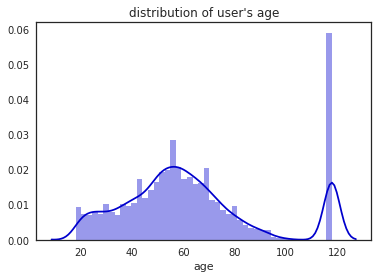

In [7]:
#Graph to plot the age of the customers
plt.figure
plt.title('distribution of user\'s age')
sns.distplot(profile['age'],color='#0000CD');

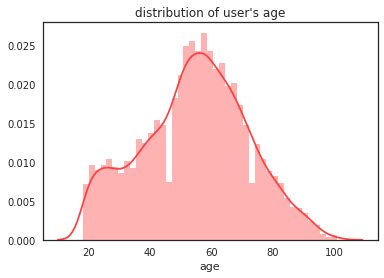

In [8]:
profile['age']=profile['age'].replace(118,np.NaN)
plt.figure()
plt.title('distribution of user\'s age')
sns.distplot(profile['age'].dropna(),color='#FF4040');
plt.show()

In [9]:
#To find mean and median of the age group 
print('Mean Age:',np.round(profile['age'].mean(),2))
print('Median Age:',np.round(profile['age'].median(),2))

Mean Age: 54.39
Median Age: 55.0


## INCOME

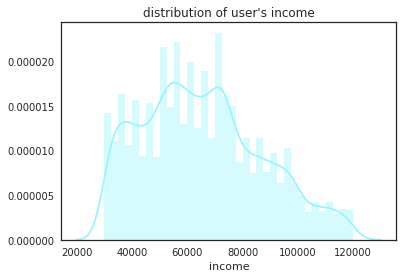

In [10]:
#Graph to plot the Income of the user
plt.figure()
plt.title('distribution of user\'s income')
sns.distplot(profile['income'].dropna(),color='#98F5FF')
plt.show()

In [11]:
#To find the mean and median between the income
print('Mean Income:',np.round(profile['income'].mean(),2))
print('Median Income:',np.round(profile['income'].median(),2))

Mean Income: 65404.99
Median Income: 64000.0


## MISSING DATA

In [12]:
display(profile.head())

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
profile['row_missing_count'] = profile[['age', 'gender', 'income']].isnull().sum(axis=1)

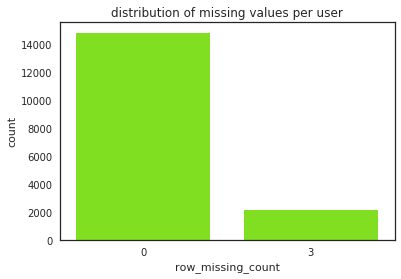

In [14]:
#Missing data
plt.figure()
plt.title('distribution of missing values per user')
sns.countplot(profile['row_missing_count'],color='#7FFF00')
plt.show()

In [15]:
profile=profile[profile['row_missing_count']==0]

In [16]:
profile=profile.drop(['row_missing_count'],axis=1)
profile = profile.rename(columns={'id' : 'profile_id'})

## GENDER

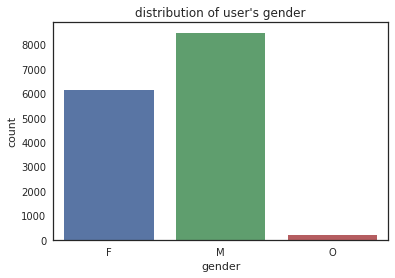

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

In [17]:
#Chart to plot the gender
plt.figure()
plt.title('distribution of user\'s gender')
sns.countplot(profile['gender'].dropna())
plt.show()
display(profile['gender'].value_counts()/len(profile))

In [18]:
gender_dummy_df = pd.get_dummies(profile['gender'])
profile = profile.join(gender_dummy_df)
profile = profile.drop(['gender'], axis=1)

## TENURE

In [19]:
display(profile['became_member_on'].head())

1     20170715
3     20170509
5     20180426
8     20180209
12    20171111
Name: became_member_on, dtype: int64

In [20]:
#To find the maximum user sign up date
print('Max user sign up date :', profile['became_member_on'].max())

Max user sign up date : 20180726


In [21]:
profile['ref_date'] = '20190101'

In [22]:
profile['became_member_on']=profile['became_member_on'].astype(str)
profile['became_member_on']=pd.to_datetime(profile['became_member_on'])
profile['ref_date']=pd.to_datetime(profile['ref_date'])

In [23]:
profile['tenure'] = profile['ref_date'] - profile['became_member_on']
profile['tenure'] = profile['tenure'].astype('timedelta64[D]')

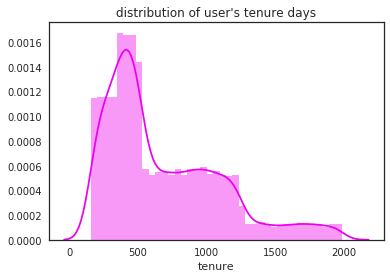

In [24]:
#Graph about the distribution of user's tenure days
plt.figure()
plt.title('distribution of user\'s tenure days')
sns.distplot(profile['tenure'],color='#EE00EE')
plt.show()

In [25]:
profile=profile.drop(['became_member_on','ref_date'],axis=1)

In [26]:
display(profile.head())

,age,profile_id,income,F,M,O,tenure
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,535.0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,602.0
5,68.0,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,250.0
8,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,326.0
12,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,416.0


# DATA PREPARATION

## TRANSCRIPT

## QUESTION 1: How to find the number of offer events completed by the customers?

In [27]:
display(transcript.head())

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [28]:
transcript = transcript.rename(columns={'person' : 'profile_id'})

In [29]:
print(transcript['event'].drop_duplicates().values)

['offer received' 'offer viewed' 'transaction' 'offer completed']


In [30]:
#To find received,viewed,completed,transaction of offers
received_df = transcript[transcript['event'] == 'offer received']
viewed_df = transcript[transcript['event'] == 'offer viewed']
completed_df = transcript[transcript['event'] == 'offer completed']
txn_df = transcript[transcript['event'] == 'transaction']

## OFFER RECEIVED EVENT 

In [31]:
display(received_df.head())

,event,profile_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [32]:
received_df['offer_id'] = received_df['value'].apply(lambda x: x['offer id'])

In [33]:
received_df = received_df.rename(columns={'time' : 'received_time'})
received_df = received_df.drop(['event', 'value'], axis=1)

In [34]:
received_df = received_df.merge(portfolio, on=['offer_id'])

In [35]:
#received offer
received_df['expiry_time'] = received_df['received_time'] + 24 * received_df['duration']
received_df['expiry_time'] = received_df['expiry_time'].astype(int)

In [36]:
display(received_df.head())

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168


#### OFFER VIEWED EVENT

In [38]:
display(viewed_df.head())

,event,profile_id,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [39]:
viewed_df['offer_id']=viewed_df['value'].apply(lambda x: x['offer id'])

In [40]:
#Viewed offer
viewed_df = viewed_df.rename(columns={'time' : 'viewed_time'})
viewed_df['viewed_time'] = viewed_df['viewed_time'].astype(int)
viewed_df = viewed_df.drop(['event', 'value'], axis=1)

In [41]:
display(viewed_df.head())

,profile_id,viewed_time,offer_id
12650,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837


#### OFFER COMPLETED EVENT

In [42]:
display(completed_df.head())

,event,profile_id,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [43]:
completed_df['offer_id']=completed_df['value'].apply(lambda x: x['offer_id'])

In [44]:
#Completed offer
completed_df = completed_df.rename(columns={'time' : 'completed_time'})
completed_df['completed_time'] = completed_df['completed_time'].astype(int)
completed_df = completed_df.drop(['event', 'value'], axis=1)

In [45]:
display(completed_df.head())

,profile_id,completed_time,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0


### RECEIVED AND VIEWED EVENT

In [47]:
receive_and_view = received_df.merge(viewed_df, on=['profile_id', 'offer_id'], how='left')

In [48]:
print('Received and View row count:', len(receive_and_view))
print('Original Viewed event count:', len(viewed_df))

Received and View row count: 95321
Original Viewed event count: 57725


In [49]:
receive_and_view = receive_and_view[(receive_and_view['viewed_time'] >= receive_and_view['received_time'])]

In [50]:
print('Received and View row count:', len(receive_and_view))
print('Original Viewed event count:', len(viewed_df))

Received and View row count: 68404
Original Viewed event count: 57725


In [51]:
#Received and viewed offer list
view_count = receive_and_view.groupby(['profile_id', 'offer_id', 'viewed_time'])['received_time'].count().reset_index()
duplicated_view_count = view_count[view_count['received_time'] > 1].sort_values(by='received_time', ascending=False)
non_duplicated_view_count = view_count[view_count['received_time'] == 1]
display(duplicated_view_count.head())
duplicated_view_count = duplicated_view_count[['profile_id', 'offer_id', 'viewed_time']]
non_duplicated_view_count = non_duplicated_view_count[['profile_id', 'offer_id', 'viewed_time']]

,profile_id,offer_id,viewed_time,received_time
53868,eece6a9a7bdd4ea1b0f812f34fc619d6,5a8bc65990b245e5a138643cd4eb9837,576.0,5
10189,2ea50de315514ccaa5079db4c1ecbc0b,fafdcd668e3743c1bb461111dcafc2a4,576.0,5
7653,23d67a23296a485781e69c109a10a1cf,5a8bc65990b245e5a138643cd4eb9837,582.0,5
24531,6d2db3aad94648259e539920fc2cf2a6,f19421c1d4aa40978ebb69ca19b0e20d,588.0,5
42113,b993a783cfe844848fc165a1de3926b1,3f207df678b143eea3cee63160fa8bed,582.0,4


In [52]:
display(receive_and_view.merge(duplicated_view_count.head(1)[['profile_id', 'offer_id']], on=['profile_id', 'offer_id']))

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,viewed_time
0,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,72,90.0
1,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,72,174.0
2,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,72,414.0
3,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,72,516.0
4,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,72,576.0
5,eece6a9a7bdd4ea1b0f812f34fc619d6,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,240,174.0
6,eece6a9a7bdd4ea1b0f812f34fc619d6,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,240,414.0
7,eece6a9a7bdd4ea1b0f812f34fc619d6,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,240,516.0
8,eece6a9a7bdd4ea1b0f812f34fc619d6,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,240,576.0
9,eece6a9a7bdd4ea1b0f812f34fc619d6,408,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,0,1,1,480,414.0


In [53]:
#find the duplicated views
non_duplicated_views = receive_and_view.merge(non_duplicated_view_count, on=['profile_id', 'offer_id', 'viewed_time'])
non_duplicated_views['not_duplicated'] = 1
checker_viewed = non_duplicated_views[['profile_id', 'offer_id', 'received_time', 'not_duplicated']].drop_duplicates()
duplicated_views = receive_and_view.merge(duplicated_view_count, on=['profile_id', 'offer_id', 'viewed_time'])
duplicated_views = duplicated_views.merge(checker_viewed, on=['profile_id','offer_id','received_time'], how='left')
duplicated_views['not_duplicated'] = duplicated_views['not_duplicated'].fillna(0)
duplicated_views = duplicated_views[duplicated_views['not_duplicated'] == 0]

In [54]:
display(duplicated_views.head())

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,viewed_time,not_duplicated
0,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,714.0,0.0
1,ebe7ef46ea6f4963a7dd49f501b26779,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,744,714.0,0.0
3,32fbf97e89274e8a935903f2ad095e1f,336,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,504,360.0,0.0
5,d1a6fe4c241e4dbf8a4da6fd6c714ac5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,336,192.0,0.0
6,bbeb54e861614fc7b22a8844f72dca6c,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,528.0,0.0


In [55]:
duplicated_views['same_offer_receive_order'] = duplicated_views.sort_values(by='received_time', ascending=False)\
.groupby(['profile_id', 'offer_id'])['received_time'].rank(method='dense')
duplicated_views['same_offer_view_order'] = duplicated_views.sort_values(by='viewed_time', ascending=True)\
.groupby(['profile_id', 'offer_id'])['viewed_time'].rank(method='dense')

In [56]:
fixed_duplicated_views = duplicated_views[(duplicated_views['same_offer_receive_order'] == duplicated_views['same_offer_view_order'])]
fixed_duplicated_views = fixed_duplicated_views.drop(['same_offer_receive_order', 'same_offer_view_order'], axis=1)

In [57]:
receive_and_view = pd.concat([non_duplicated_views, fixed_duplicated_views])

In [58]:
#Display received and viewed offer list
check_view_df = receive_and_view.groupby(['profile_id', 'offer_id', 'viewed_time'])['received_time']\
    .count().reset_index()
check_view_df_2 = receive_and_view.groupby(['profile_id', 'offer_id', 'received_time'])['viewed_time']\
    .count().reset_index()
display(check_view_df.sort_values(by=['received_time'], ascending=False).head())
display(check_view_df_2.sort_values(by=['viewed_time'], ascending=False).head())

,profile_id,offer_id,viewed_time,received_time
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.0,1
38447,a97e140cf0094644a99290c1172f7d18,2906b810c7d4411798c6938adc9daaa5,378.0,1
38477,a99e6dc6e2db4882a07f4280db7de088,ae264e3637204a6fb9bb56bc8210ddfd,528.0,1
38478,a99e6dc6e2db4882a07f4280db7de088,f19421c1d4aa40978ebb69ca19b0e20d,594.0,1
38479,a99e6dc6e2db4882a07f4280db7de088,fafdcd668e3743c1bb461111dcafc2a4,450.0,1


,profile_id,offer_id,received_time,viewed_time
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,1
38447,a97e140cf0094644a99290c1172f7d18,2906b810c7d4411798c6938adc9daaa5,336,1
38477,a99e6dc6e2db4882a07f4280db7de088,ae264e3637204a6fb9bb56bc8210ddfd,504,1
38478,a99e6dc6e2db4882a07f4280db7de088,f19421c1d4aa40978ebb69ca19b0e20d,576,1
38479,a99e6dc6e2db4882a07f4280db7de088,fafdcd668e3743c1bb461111dcafc2a4,408,1


In [59]:
print('Received and View row count:', len(receive_and_view))
print('Original Viewed event count:', len(viewed_df))

Received and View row count: 57725
Original Viewed event count: 57725


In [60]:
receive_and_view = receive_and_view[['profile_id', 'received_time', 'offer_id', 'viewed_time']]

### COMPLETED AND RECEIVED EVENT

In [61]:
completed_df['dummy_count'] = 1

In [62]:
display(completed_df.groupby(['profile_id', 'offer_id', 'completed_time'])['dummy_count']\
        .sum().sort_values(ascending=False).reset_index().head())

,profile_id,offer_id,completed_time,dummy_count
0,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,510,3
1,6fa9ef8890bc467699ce92f2679a4178,f19421c1d4aa40978ebb69ca19b0e20d,624,2
2,9b2ec72a4ee04bb1bbf360642f22e7d3,fafdcd668e3743c1bb461111dcafc2a4,630,2
3,b669b308d4fa4bff837d68d86a78e6b1,9b98b8c7a33c4b65b9aebfe6a799e6d9,510,2
4,d19849e046cc441fb7cfc4c8a68dbf6d,0b1e1539f2cc45b7b9fa7c272da2e1d7,600,2


In [63]:
completed_df['dummy_rank'] = completed_df.groupby(['profile_id', 'offer_id', 'completed_time'])['dummy_count']\
    .rank(method='first')

In [64]:
display(completed_df[(completed_df['profile_id'] == '3526938fb466470190a504a751ec07b0') &(completed_df['offer_id'] == '0b1e1539f2cc45b7b9fa7c272da2e1d7')])

,profile_id,completed_time,offer_id,dummy_count,dummy_rank
220615,3526938fb466470190a504a751ec07b0,510,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1.0
220616,3526938fb466470190a504a751ec07b0,510,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,2.0
220617,3526938fb466470190a504a751ec07b0,510,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,3.0


In [65]:
completed_df['dummy_completed_time'] = completed_df['completed_time'] + completed_df['dummy_rank'] / 10

In [66]:
receive_and_complete = received_df.merge(completed_df, on=['profile_id', 'offer_id'])

In [67]:
receive_and_complete = receive_and_complete[(receive_and_complete['completed_time'] >= receive_and_complete['received_time']) &(receive_and_complete['completed_time'] <= receive_and_complete['expiry_time'])]

In [68]:
#Completed and received offer list
print('Received and Completed row count:', len(receive_and_complete))
print('Original Completed event count:', len(completed_df))

Received and Completed row count: 35376
Original Completed event count: 33579


In [69]:
complete_count = receive_and_complete.groupby(['profile_id', 'offer_id', 'completed_time'])['received_time'].count().reset_index()
duplicated_complete_count = complete_count[complete_count['received_time'] > 1].sort_values(by='received_time', ascending=False)
non_duplicated_complete_count = complete_count[complete_count['received_time'] == 1]
display(duplicated_complete_count.head())
duplicated_complete_count = duplicated_complete_count[['profile_id', 'offer_id', 'completed_time']]
non_duplicated_complete_count = non_duplicated_complete_count[['profile_id', 'offer_id', 'completed_time']]

,profile_id,offer_id,completed_time,received_time
6860,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,510,9
6920,35b3206b05304a518114bee3e113af09,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,6
5994,2ea50de315514ccaa5079db4c1ecbc0b,fafdcd668e3743c1bb461111dcafc2a4,528,6
11731,5a7136999fa240838c28e52359f6533d,fafdcd668e3743c1bb461111dcafc2a4,618,6
19873,99148a450059428180ed37cb9ab01f62,2906b810c7d4411798c6938adc9daaa5,642,4


In [70]:
display(receive_and_complete.merge(duplicated_complete_count.head(1)[['profile_id', 'offer_id']], on=['profile_id', 'offer_id']))

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,completed_time,dummy_count,dummy_rank,dummy_completed_time
0,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,576,510,1,1.0,510.1
1,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,576,510,1,2.0,510.2
2,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,576,510,1,3.0,510.3
3,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,648,510,1,1.0,510.1
4,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,648,510,1,2.0,510.2
5,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,648,510,1,3.0,510.3
6,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,744,510,1,1.0,510.1
7,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,744,510,1,2.0,510.2
8,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,744,510,1,3.0,510.3


In [71]:
#find and remove the duplicate list
non_duplicated_completes = receive_and_complete\
    .merge(non_duplicated_complete_count, on=['profile_id', 'offer_id', 'completed_time'])
non_duplicated_completes['not_duplicated'] = 1
checker_completed = non_duplicated_completes[['profile_id', 'offer_id', 'received_time', 'not_duplicated']].drop_duplicates()
duplicated_completes = receive_and_complete.merge(duplicated_complete_count, on=['profile_id', 'offer_id', 'completed_time'])
duplicated_completes = duplicated_completes.merge(checker_completed, on=['profile_id','offer_id','received_time'], how='left')
duplicated_completes['not_duplicated'] = duplicated_completes['not_duplicated'].fillna(0)
duplicated_completes = duplicated_completes[duplicated_completes['not_duplicated'] == 0]

In [72]:
duplicated_completes['same_offer_receive_order'] = duplicated_completes.sort_values(by='received_time', ascending=True).groupby(['profile_id', 'offer_id'])['received_time'].rank(method='dense')
duplicated_completes['same_offer_complete_order'] = duplicated_completes.sort_values(by='dummy_completed_time', ascending=True).groupby(['profile_id', 'offer_id'])['dummy_completed_time'].rank(method='dense')

In [73]:
duplicated_completes[duplicated_completes['profile_id'] == '3526938fb466470190a504a751ec07b0']

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,completed_time,dummy_count,dummy_rank,dummy_completed_time,not_duplicated,same_offer_receive_order,same_offer_complete_order
434,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,576,510,1,1.0,510.1,0.0,1.0,1.0
435,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,576,510,1,2.0,510.2,0.0,1.0,2.0
436,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,576,510,1,3.0,510.3,0.0,1.0,3.0
437,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,648,510,1,1.0,510.1,0.0,2.0,1.0
438,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,648,510,1,2.0,510.2,0.0,2.0,2.0
439,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,648,510,1,3.0,510.3,0.0,2.0,3.0
440,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,744,510,1,1.0,510.1,0.0,3.0,1.0
441,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,744,510,1,2.0,510.2,0.0,3.0,2.0
442,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0,744,510,1,3.0,510.3,0.0,3.0,3.0


In [74]:
fixed_duplicated_completes = duplicated_completes[(duplicated_completes['same_offer_receive_order'] == duplicated_completes['same_offer_complete_order'])]
fixed_duplicated_completes = fixed_duplicated_completes.drop(['same_offer_receive_order', 'same_offer_complete_order'], axis=1)

In [75]:
receive_and_complete = pd.concat([non_duplicated_completes, fixed_duplicated_completes])

In [76]:
#Completed and received offers
check_complete_df = receive_and_complete.groupby(['profile_id', 'offer_id', 'completed_time'])['received_time'].count().reset_index()
check_complete_df_2 = receive_and_complete.groupby(['profile_id', 'offer_id', 'received_time'])['completed_time'].count().reset_index()
display(check_complete_df.sort_values(by=['received_time'], ascending=False).head())
display(check_complete_df_2.sort_values(by=['completed_time'], ascending=False).head())

,profile_id,offer_id,completed_time,received_time
6860,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,510,3
18099,8b9d3f738e7e499b9e820de07c16bc62,2906b810c7d4411798c6938adc9daaa5,630,2
13727,69743d51492d4173b0e054fd5d8f943c,f19421c1d4aa40978ebb69ca19b0e20d,576,2
14244,6d6c0aa032064438b97ab5dc28fd1b61,9b98b8c7a33c4b65b9aebfe6a799e6d9,432,2
2010,0f6cf9619c4341e89a099e951300a2ea,0b1e1539f2cc45b7b9fa7c272da2e1d7,552,2


,profile_id,offer_id,received_time,completed_time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,1
22396,a960ae2cd3d04791ac3ca5799a2ad01a,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1
22394,a95c94e9e8444d3ea4e10d2b96c6bba4,ae264e3637204a6fb9bb56bc8210ddfd,0,1
22393,a95c8b2d84b04c22b525d6fec9e1dda3,fafdcd668e3743c1bb461111dcafc2a4,336,1
22392,a95c8b2d84b04c22b525d6fec9e1dda3,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,1


In [77]:
#Display the received and completed offers 
print('Received and Completed row count:', len(receive_and_complete))
print('Original Completed event count:', len(completed_df))

Received and Completed row count: 33579
Original Completed event count: 33579


In [78]:
receive_and_complete = receive_and_complete[['profile_id', 'received_time', 'offer_id', 'completed_time']]

In [79]:
experiment_df = received_df.merge(receive_and_view, on=['profile_id', 'received_time', 'offer_id'], how='left')\
    .merge(receive_and_complete, on=['profile_id', 'received_time', 'offer_id'], how='left')

In [80]:
experiment_df['is_viewed'] = pd.notnull(experiment_df['viewed_time'])
experiment_df['is_completed'] = pd.notnull(experiment_df['completed_time'])

In [81]:
display(experiment_df.head())

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,viewed_time,completed_time,is_viewed,is_completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,6.0,132.0,True,True
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,714.0,NaN,True,False
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,48.0,12.0,True,True
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,30.0,66.0,True,True
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0,168,NaN,NaN,False,False


### TRANSACTIONS DATA

In [82]:
display(txn_df.head())

,event,profile_id,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [83]:
txn_df['amount']=txn_df['value'].apply(lambda x: x['amount'])

In [84]:
txn_df = txn_df.rename(columns={'time' : 'txn_time', })
txn_df = txn_df.drop(['event', 'value'], axis=1)

In [85]:
display(txn_df.head())

,profile_id,txn_time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


40.02


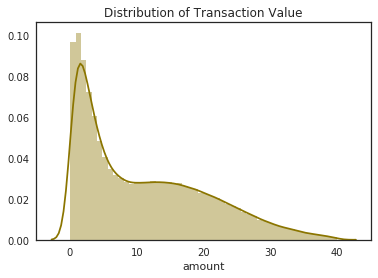

In [86]:
#Graph to plot the distribution of Transaction value
upper_lim  = np.percentile(txn_df['amount'], 99)
print(np.round(upper_lim, 2))
txn_df = txn_df[txn_df['amount'] <= upper_lim]
plt.figure()
plt.title('Distribution of Transaction Value')
sns.distplot(txn_df['amount'],color='#8B7500')
plt.show()

In [87]:
print('Mean of transaction value:', txn_df['amount'].mean())

Mean of transaction value: 11.0646034181


In [88]:
exp_txns_df = experiment_df[['profile_id', 'offer_id', 'received_time', 'viewed_time', 'completed_time', 'expiry_time']]\
    .merge(txn_df, on=['profile_id'])

In [89]:
#Number of received and viewed ,viewed and completed ,received and completed
between_received_and_view = (exp_txns_df['txn_time'] >= exp_txns_df['received_time'])\
&(exp_txns_df['txn_time'] <= exp_txns_df['viewed_time'])
between_view_and_complete = (exp_txns_df['txn_time'] >= exp_txns_df['viewed_time'])\
&(exp_txns_df['txn_time'] <= exp_txns_df['completed_time'])
between_received_and_complete = (exp_txns_df['txn_time'] >= exp_txns_df['received_time'])\
&(exp_txns_df['txn_time'] <= exp_txns_df['completed_time'])
between_received_and_expiry = (exp_txns_df['txn_time'] >= exp_txns_df['received_time'])\
&(exp_txns_df['txn_time'] <= exp_txns_df['expiry_time'])
before_received = (exp_txns_df['txn_time'] < exp_txns_df['received_time'])
exp_txns_df['between_received_and_view_amount'] = np.where(between_received_and_view, exp_txns_df['amount'], 0)
exp_txns_df['between_view_and_complete_amount'] = np.where(between_view_and_complete, exp_txns_df['amount'], 0)
exp_txns_df['between_received_and_complete_amount'] = np.where(between_received_and_complete, exp_txns_df['amount'], 0)
exp_txns_df['between_received_and_expiry_amount'] = np.where(between_received_and_expiry, exp_txns_df['amount'], 0)
exp_txns_df['before_received_amount'] = np.where(before_received, exp_txns_df['amount'], 0)
exp_txns_df['between_received_and_view_count'] = np.where(between_received_and_view, 1, 0)
exp_txns_df['between_view_and_complete_count'] = np.where(between_view_and_complete, 1, 0)
exp_txns_df['between_received_and_complete_count'] = np.where(between_received_and_complete, 1, 0)
exp_txns_df['between_received_and_expiry_count'] = np.where(between_received_and_expiry, 1, 0)
exp_txns_df['before_received_count'] = np.where(before_received, 1, 0)
cols_to_be_summed = [i for i in exp_txns_df.columns if 'between' in i or 'before' in i]

In [90]:
exp_txns_df = exp_txns_df.groupby(['profile_id', 'offer_id', 'received_time'])[cols_to_be_summed]\
    .sum().reset_index()

In [91]:
full_data_df = experiment_df.merge(exp_txns_df, on=['profile_id', 'offer_id', 'received_time'], how='left')\
    .merge(profile, on=['profile_id'])

In [92]:
for col in cols_to_be_summed:
    full_data_df[col] = full_data_df[col].fillna(0)

In [93]:
print(completed_df.merge(portfolio[['offer_id', 'offer_type']], on=['offer_id'])['offer_type']\
          .drop_duplicates().values)

['discount' 'bogo']


In [94]:
informational_complete = (full_data_df['offer_type'] == 'informational') & (full_data_df['between_received_and_expiry_amount'] > 0)
full_data_df['is_completed'] = np.where(informational_complete, 1, full_data_df['is_completed'])

In [95]:
ideal_to_send = (full_data_df['is_viewed'] == 1) & (full_data_df['is_completed'] == 1)
full_data_df['is_viewed_and_completed'] = np.where(ideal_to_send, 1, 0)

## Assessing Who Should be Targeted For a Particular Offer

### QUESTION 2 :How to predict the particular order targeted for a person?

### PERSONS TARGETED FOR PARTICULAR ORDER

In [97]:
display(np.round(full_data_df.groupby(['offer_type', 'offer_id']).agg({'profile_id' : 'count','age' : 'mean','income' : 'mean','tenure' : 'mean','M' : 'mean','F' : 'mean','O' : 'mean','is_viewed' : 'mean'}).reset_index().rename(columns={'profile_id' : 'user_count'}), 2))

,offer_type,offer_id,user_count,age,income,tenure,M,F,O,is_viewed
0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,54.28,65484.00,683.58,0.57,0.42,0.01,0.96
1,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,54.38,65155.42,687.67,0.57,0.41,0.02,0.52
2,bogo,ae264e3637204a6fb9bb56bc8210ddfd,6683,54.20,65567.41,684.53,0.57,0.41,0.01,0.88
3,bogo,f19421c1d4aa40978ebb69ca19b0e20d,6576,54.47,65493.46,674.91,0.57,0.41,0.01,0.96
4,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,54.38,65179.60,682.95,0.57,0.42,0.01,0.33
5,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,54.27,65228.10,672.28,0.58,0.41,0.01,0.96
6,discount,2906b810c7d4411798c6938adc9daaa5,6631,54.18,65467.95,679.41,0.58,0.41,0.01,0.52
7,discount,fafdcd668e3743c1bb461111dcafc2a4,6652,54.41,65401.83,681.76,0.58,0.41,0.01,0.96
8,informational,3f207df678b143eea3cee63160fa8bed,6657,54.56,65181.61,681.35,0.57,0.41,0.01,0.52
9,informational,5a8bc65990b245e5a138643cd4eb9837,6643,54.56,65562.25,680.44,0.57,0.42,0.01,0.88


## DATA MODELING

## DEMOGRAPHICS DATA

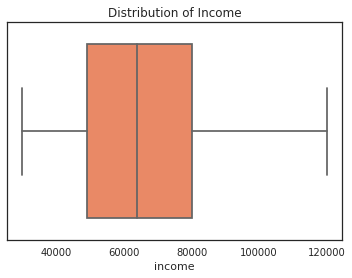

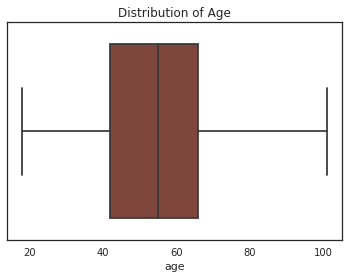

In [98]:
#demographics data of distribution of income and distribution of age
plt.figure()
plt.title('Distribution of Income')
sns.boxplot(profile['income'], color='#FF7F50')
plt.show()
plt.figure()
plt.title('Distribution of Age')
sns.boxplot(profile['age'], color='#8B3E2F')
plt.show()

In [99]:
profile['income_group'] = np.round(profile['income'] / 30000) * 30000
profile['age_group'] = np.round(profile['age'] / 20) * 20

In [100]:
viewed_df = full_data_df[full_data_df['is_viewed'] == 1]
viewed_df = viewed_df.merge(profile[['profile_id', 'income_group', 'age_group']], on=['profile_id'])

In [101]:
train_df = viewed_df.sample(int(0.8 * len(viewed_df)), random_state=100)
test_df = viewed_df[~viewed_df.index.isin(train_df.index)]

In [102]:
completion_df = train_df.groupby(['income_group', 'age_group', 'M', 'F','offer_id']).agg({'profile_id' : 'count','is_completed' : 'mean'}).reset_index().rename(columns={'profile_id' : 'user_offered','is_completed' : 'complete_probability'})

In [103]:
display(completion_df.tail())

,income_group,age_group,M,F,offer_id,user_offered,complete_probability
454,120000.0,100.0,1,0,2906b810c7d4411798c6938adc9daaa5,1,1.000000
455,120000.0,100.0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,3,1.000000
456,120000.0,100.0,1,0,5a8bc65990b245e5a138643cd4eb9837,1,1.000000
457,120000.0,100.0,1,0,ae264e3637204a6fb9bb56bc8210ddfd,2,1.000000
458,120000.0,100.0,1,0,f19421c1d4aa40978ebb69ca19b0e20d,7,0.857143


In [104]:
#accuracy,precision,recall and F1 scores
baseline_test_df = test_df.merge(completion_df, on=['income_group', 'age_group', 'M', 'F', 'offer_id'])

In [105]:
baseline_precision, baseline_recall, baseline_thresholds = precision_recall_curve(baseline_test_df['is_completed'], baseline_test_df['complete_probability'])

In [106]:
baseline_f1 = 2 * (baseline_precision * baseline_recall) / (baseline_precision + baseline_recall)

In [107]:
best_f1_baseline_threshold = baseline_thresholds[np.argsort(-baseline_f1)[0]]

In [108]:
completion_df['send_offer'] = np.where(completion_df['complete_probability'] >= best_f1_baseline_threshold, 1, 0)
baseline_test_df['prediction'] = np.where(baseline_test_df['complete_probability'] >= best_f1_baseline_threshold, 1, 0)
roc_baseline = np.where(baseline_test_df['complete_probability'] >= best_f1_baseline_threshold, 1, 0)

In [109]:
baseline_y_preds = baseline_test_df['prediction'].values
baseline_y_test = baseline_test_df['is_completed'].values

In [110]:
#To print the accuracy,precision,recall,F1 scores
print('Accuracy Score on Test Set: ', np.round(accuracy_score(baseline_y_test, baseline_y_preds),2))
print('Precision Score on Test Set: ', np.round(precision_score(baseline_y_test, baseline_y_preds),2))
print('Recall Score on Test Set: ', np.round(recall_score(baseline_y_test, baseline_y_preds),2))
print('F1 Score on Test Set: ', np.round(f1_score(baseline_y_test, baseline_y_preds),2))

Accuracy Score on Test Set:  0.69
Precision Score on Test Set:  0.69
Recall Score on Test Set:  0.98
F1 Score on Test Set:  0.81


## QUESTION 3: How to find who got highest response rate?

#### HIGHEST RESPONSE RATE

In [111]:
#To find the highest response rate
best_demographic_df = completion_df[completion_df['user_offered'] > 10].sort_values(by=['offer_id', 'complete_probability'], ascending=[True, False])\
    .groupby(['offer_id']).head(3)
best_demographic_df = best_demographic_df.merge(portfolio[['offer_type','offer_id', 'difficulty', 'reward']], on=['offer_id'])
best_demographic_df = best_demographic_df[['offer_type', 'offer_id', 'difficulty', 'reward', 'income_group', 'age_group', 'M', 'F', 'complete_probability']]
display(best_demographic_df)

,offer_type,offer_id,difficulty,reward,income_group,age_group,M,F,complete_probability
0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,60000.0,60.0,0,0,0.909091
1,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,120000.0,60.0,0,1,0.904762
2,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,90000.0,80.0,0,1,0.850000
3,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,7,3,120000.0,60.0,0,1,0.876033
4,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,7,3,120000.0,80.0,1,0,0.869565
5,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,7,3,90000.0,80.0,0,1,0.847953
6,discount,2906b810c7d4411798c6938adc9daaa5,10,2,90000.0,80.0,1,0,0.835443
7,discount,2906b810c7d4411798c6938adc9daaa5,10,2,60000.0,40.0,0,1,0.801075
8,discount,2906b810c7d4411798c6938adc9daaa5,10,2,60000.0,60.0,0,0,0.800000
9,informational,3f207df678b143eea3cee63160fa8bed,0,0,60000.0,20.0,1,0,0.863014


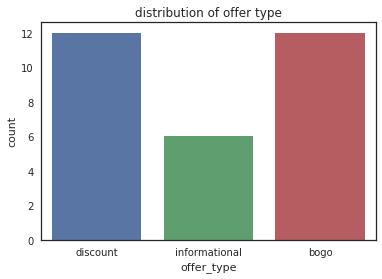

In [112]:
#Chart to plot the distribution of offer type
plt.figure()
plt.title('distribution of offer type')
sns.countplot(best_demographic_df['offer_type'].dropna())
plt.show()

## CONCLUSION